In [100]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [101]:
os.chdir('/Users/chowshengyang/Desktop/BT4222_Group_Project/data')
transaction_train = pd.read_csv('train_transaction.csv')
transaction_train


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
def header(text):
    print(f"\033[94m\033[1m", text, f"\033[0m")

def num_nulls(df, perc=False) -> dict:
    nulls_dict = {}
    for col in df.columns:
        num_nulls = int(df[col].isnull().sum())
        if perc == True:
            nulls_dict[col] = (num_nulls / len(df[col])) * 100
        else:
            nulls_dict[col] = num_nulls
    return nulls_dict

def split_features(df, split_by):
    others = df.drop(columns=split_by)
    split = df.loc[:, split_by]
    return split, others

def extract_df(df):
    num_cols = list(df.select_dtypes('number').columns)
    cat_cols = [j for j in df.columns if j not in num_cols]
    numeric, cat = split_features(df, split_by=num_cols)
    return numeric, cat

def preprocess_data(
        df,
        target:str,
        remove_nulls_threshold:int,
        remove_nulls=False, 
        display_nulls=False,
        interpolate=False,
        standardise=False,
        ) -> pd.DataFrame:
    
    # split independent & target:
    y, Xs = split_features(df, target)
    
    k = len(Xs.columns)
    
    # work on Y feature:
    if y.isnull().sum() > 0:
        y.interpolate(limit_area='inside')
        print('Target Feature has missing values being interpolated.')
    elif y.unique().sum() != 1:
        print('Target Feature is not binary.')
    else:
        y = pd.to_numeric(y)

    # remove any columns with constant values
    Xs = Xs[Xs.columns[Xs.nunique() > 1]]
    header('Number of Columns with constant values dropped:') 
    print(f'{k - len(Xs.columns)}')

    # replace any non-NaN missing values with NaN
    Xs = Xs.replace([float('inf'), float('-inf'), None, 'NULL', 'Null', 'null'], float('nan'))
    
    if interpolate is True:
        Xs = Xs.interpolate(limit_area='inside')
        header(f'Features with missing values interpolated.')
        
    # remove any columns that have > x null values
    if remove_nulls is True:
        null_dict = num_nulls(Xs, perc=True)
        nullcols = [i for i in null_dict.keys() if null_dict[i] >= remove_nulls_threshold]
        Xs = Xs.loc[:, [c for c in Xs.columns if c not in nullcols]]
        header('Number of Columns with > 50% NaN droped:')
        print(f'{len(nullcols)}')

    if display_nulls is True:
        display(pd.DataFrame(list(null_dict.items()), columns=['Feature', 'Percentage_Null']) \
                .set_index('Feature') \
                .sort_values(by='Percentage_Null', ascending=False) \
                .head(10))

    # standardise numerical columns
    if standardise is True:
        z = StandardScaler()
        num, cat = extract_df(Xs)
        for col in num:
            Xs[col] = Xs[col] if col == 'TransactionID' else z.fit_transform(Xs[col].to_numpy().reshape(-1, 1))

    # encode any bool columns and any strings labelled T/F to 1/0
    Xs[Xs.columns[Xs.dtypes == 'bool']] += 0
    for x in Xs.columns:
        if ('T' in set(Xs[x])) or ('F' in set(Xs[x])):
            Xs[x] = Xs[x].replace('T', 1).replace('F', 0)

    # rejoin Xs and Y features
    newdf = pd.concat([Xs, y], axis=1)

    return newdf

# TRANSACTION DATA

In [103]:
# engineer log_transactionamt:
transaction_train['log_TransactionAmt'] = np.log(transaction_train['TransactionAmt'])

# preprocess transaction_train:
cleaned_transaction_train = preprocess_data(df=transaction_train,
                                            target='isFraud',
                                            remove_nulls=True,
                                            remove_nulls_threshold=50,
                                            display_nulls=True,
                                            interpolate=False,
                                            standardise=False)

header('Preprocessed Training Data:')
display(cleaned_transaction_train)

# # correlation matrix:
# header('Correlation Matrix for pairwise r > 0.5:')
# numerics, categoricals = extract_df(cleaned_transaction_train)
# pearsonr = numerics.corr()
# display(pearsonr[pearsonr > 0.5])

 Number of Columns with constant values dropped: 
0
 Number of Columns with > 50% NaN droped: 
174


,Percentage_Null
Feature,
dist2,93.628374
D7,93.409930
D13,89.509263
D14,89.469469
D12,89.041047
D6,87.606767
D8,87.312290
D9,87.312290
V155,86.123717


 Preprocessed Training Data: 


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V314,V315,V316,V317,V318,V319,V320,V321,log_TransactionAmt,isFraud
0,2987000,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,...,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,4.226834,0
1,2987001,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.367296,0
2,2987002,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.077537,0
3,2987003,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,0.000000,0.000000,50.0,1404.0,790.0,0.000000,0.000000,0.000000,3.912023,0
4,2987004,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.912023,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,...,47.950001,47.950001,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.891820,0
590536,3577536,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.676301,0
590537,3577537,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.432373,0
590538,3577538,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,...,669.500000,317.500000,0.0,2234.0,0.0,0.000000,0.000000,0.000000,4.762174,0


 Datatypes of each Feature: 
{dtype('O'), dtype('float64'), dtype('int64')}
 Visualise _isFraud: 


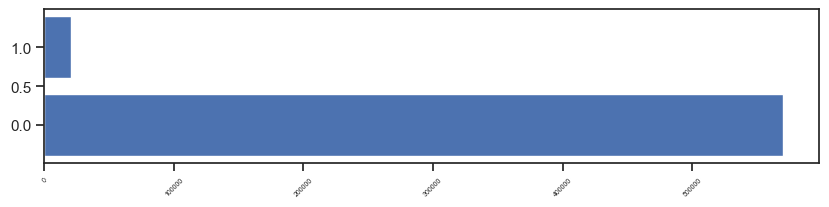

 Visualise _TransactionAmt: 


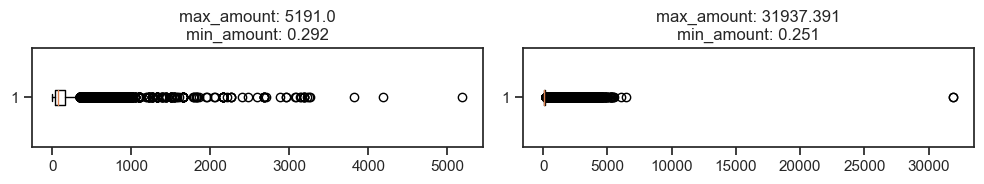

 Visualise log_TransactionAmt: 


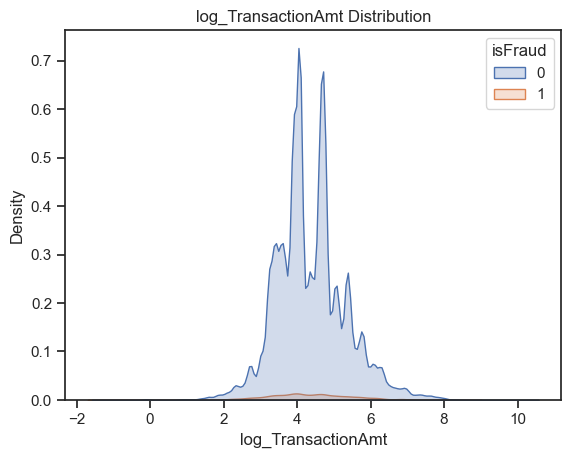

 Visualise _ProductCD: 


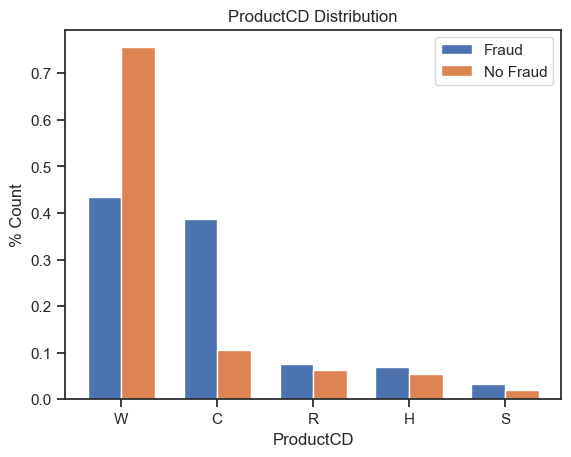

 Visualise _card4: 


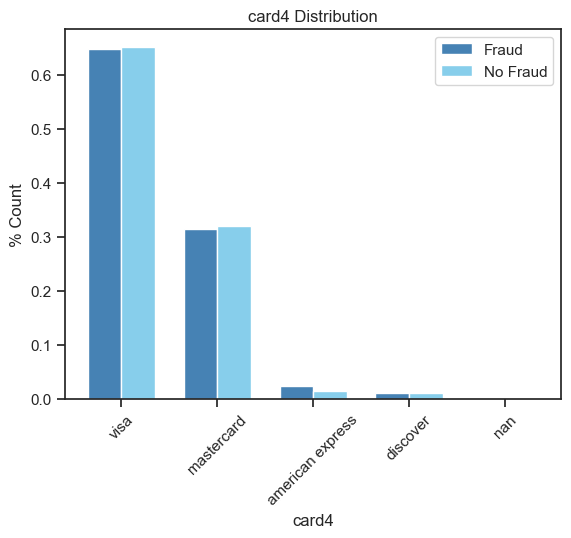

In [104]:
fs=(10, 2)

# datatypes of each feature:
header("Datatypes of each Feature:")
print(set(cleaned_transaction_train.dtypes))

# EDA on _isFraud:
header('Visualise _isFraud:')
plt.figure(figsize=fs)
isfraud = cleaned_transaction_train.isFraud.value_counts().to_dict()
plt.barh(list(isfraud.keys()), list(isfraud.values()))
plt.xticks(rotation=45, fontsize=5)
plt.show()

# EDA on _TransactionAmt:
header('Visualise _TransactionAmt:')
fraud_cond, no_fraud_cond = cleaned_transaction_train['isFraud'] == 1, cleaned_transaction_train['isFraud'] == 0
T_Amt_Fraud = cleaned_transaction_train[fraud_cond]['TransactionAmt'].to_numpy()
T_Amt_NoFraud = cleaned_transaction_train[no_fraud_cond]['TransactionAmt'].to_numpy()

fig, axs = plt.subplots(1, 2, figsize=fs, tight_layout=True)

axs[0].boxplot(T_Amt_Fraud, vert=False)
axs[0].set_title(f'max_amount: {max(T_Amt_Fraud)}\nmin_amount: {min(T_Amt_Fraud)}')
axs[1].boxplot(T_Amt_NoFraud, vert=False)
axs[1].set_title(f'max_amount: {max(T_Amt_NoFraud)}\nmin_amount: {min(T_Amt_NoFraud)}')

plt.show()

del fig, axs

# EDA on _log_TransactionAmt:
header('Visualise log_TransactionAmt:')
sns.kdeplot(data=cleaned_transaction_train, 
            x='log_TransactionAmt', hue='isFraud',
            multiple='layer',
            fill=True)

plt.title('log_TransactionAmt Distribution')
plt.show()

# EDA on _ProductCD:
header('Visualise _ProductCD:')

bar_width = 0.35
x = np.arange(len(set(cleaned_transaction_train['ProductCD'])))
fig, ax = plt.subplots()

CD_Fraud = cleaned_transaction_train[fraud_cond]['ProductCD'].value_counts(normalize=True, dropna=False)
bar1 = ax.bar(x - bar_width/2, CD_Fraud, bar_width, label='Fraud')
CD_NoFraud = cleaned_transaction_train[no_fraud_cond]['ProductCD'].value_counts(normalize=True, dropna=False)
bar2 = ax.bar(x + bar_width/2, CD_NoFraud, bar_width, label='No Fraud')

ax.set_xlabel('ProductCD')
ax.set_ylabel('% Count')
ax.set_title('ProductCD Distribution')
ax.set_xticks(x)
ax.set_xticklabels(cleaned_transaction_train['ProductCD'].value_counts().keys())
ax.legend()

plt.show()

del fig, ax, x, bar1, bar2

# EDA on _card4:
header('Visualise _card4:')

x = np.arange(len(set(cleaned_transaction_train['card4'])))
fig, ax = plt.subplots()

# Plot the bars for Class 1
card4_Fraud = cleaned_transaction_train[fraud_cond]['card4'].value_counts(normalize=True, dropna=False)
bar1 = ax.bar(x - bar_width/2, card4_Fraud, bar_width, label='Fraud', color='steelblue')
# Plot the bars for Class 2
card4_NoFraud = cleaned_transaction_train[no_fraud_cond]['card4'].value_counts(normalize=True, dropna=False)
bar2 = ax.bar(x + bar_width/2, card4_NoFraud, bar_width, label='No Fraud', color='skyblue')

ax.set_xlabel('card4')
ax.set_ylabel('% Count')
ax.set_title('card4 Distribution')
ax.set_xticks(x)
ax.set_xticklabels(cleaned_transaction_train['card4'].value_counts(normalize=True, dropna=False).keys(),
                   rotation=45)
ax.legend()

plt.show()

del fig, ax


